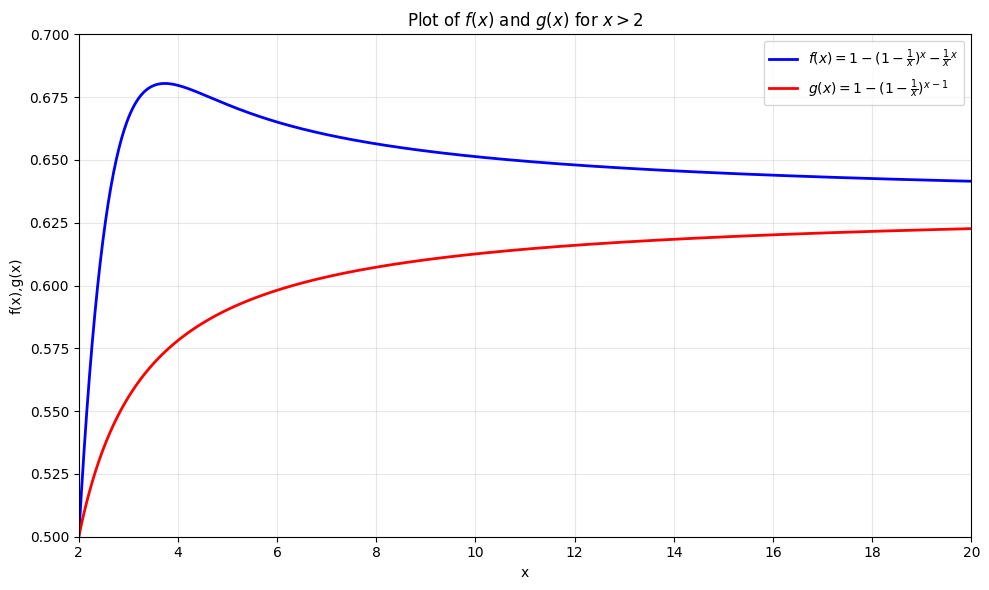

Sample values:
f(3) = 0.666667
f(5) = 0.672000
f(10) = 0.651322
f(15) = 0.644736
f(20) = 0.641514


In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function f(x) = 1 - (1 - 1/x)^x - 1/x
def f(x):
    return 1 - (1 - 1/x)**x - 1/x**x
def g(x):
    return 1 -(1-1/x)**(x-1)

# Create x values from just above 2 to avoid any issues at x=2
x = np.linspace(2, 20, 1000)

# Calculate y values
y = f(x)
y1 = g(x)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'b-', linewidth=2, label=r'$f(x) = 1 - (1 - \frac{1}{x})^x - \frac{1}{x}^x$')
plt.plot(x, y1, 'r-', linewidth=2, label=r'$g(x) = 1 - (1 - \frac{1}{x})^{x-1}$')
plt.grid(True, alpha=0.3)
plt.xlabel('x')
plt.ylabel('f(x),g(x)')
plt.title(r'Plot of $f(x)$ and $g(x)$ for $x > 2$')
plt.legend()
plt.xlim(2, 20)
plt.ylim(0.5, 0.7)

# Add horizontal line at y=0 for reference
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Print some sample values
print("Sample values:")
for x_val in [3, 5, 10, 15, 20]:
    print(f"f({x_val}) = {f(x_val):.6f}")

In [2]:
pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 45.4 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [22]:
from pulp import *

# --- 1. Define the Problem Parameters ---
# Let's set the size of the vector 'v' to n.
# The index k runs from 1 to n-1, so the vector v has n components: v_1, v_2, ..., v_n.
# Note: In PuLP and Python, we often use 0-based indexing.
# For simplicity, we'll keep the problem definition 1-based and translate later.
#n = 2048  # Example size: v_1, v_2, v_3, v_4, v_5 (n=5)

def solve_lp(n,h=16):
    """
    Solves the updated linear program for a given size n and returns the minimum objective value y.
    """
    if n < 2:
        return None
    # --- 2. Initialize the LP Problem ---
    # We are minimizing 'y'
    prob = LpProblem("Minimization_Problem", LpMinimize)

    # --- 3. Define the Variables ---

    # a) Variable 'y' (The objective variable, unbounded in principle)
    y = LpVariable("y")

    # b) Variables v_1, v_2, ..., v_n (n total variables)
    # We can define them using a dictionary for easy indexing.
    # The variables are v_1, ..., v_n.
    # The constraints state: 1 <= v_k <= 100 for k=1 to n-1.
    # We'll apply the specific v_1=100 and bounds as constraints.

    # Create the v_k variables for k=1 to n (total of n variables)
    v_vars = LpVariable.dicts("v", range(1, n + 1), lowBound=1, upBound=h)

    # --- 4. Define the Objective Function ---
    # Minimize y
    prob += y, "Objective Function: Minimize y"

    # --- 5. Define the Constraints ---

    # Constraint 1: Initial condition (v_1 = 100)
    # PuLP needs this as two separate bounds, or you can simplify the definition:
    prob += v_vars[1] == h, "Initial_Condition_v1"

    # Constraint 2: General Bounds (1 <= v_k <= 100 for k=1 to n-1)
    # Note: We set lowBound=1 and upBound=100 when defining v_vars, so this is covered for k=1 to n.
    # We will explicitly constrain v_n later if its bounds differ. Assuming v_n is also [1, 100].

    # Constraint 3: Monotonicity (v_{k+1} <= v_k for k=1 to n-1)
    # This iterates through k=1, 2, ..., n-1
    for k in range(1, n):
        prob += v_vars[k+1] <= v_vars[k], f"Monotonicity_v{k+1}_le_v{k}"

    # Constraint 4: Core LP inequality (y >= ...)
    # This iterates through k=1, 2, ..., n-1
    for k in range(1, n):
        # Summation term: sum(v_i) from i=1 to k
        sum_vk = lpSum(v_vars[i] for i in range(1, k + 1))

        # The constraint is: y >= (sum_{i=1}^k v_i) / k - v_{k+1}
        # To keep it linear, we multiply by k: k*y >= sum_{i=1}^k v_i - k*v_{k+1}
        # Rearrange: k*y - sum_{i=1}^k v_i + k*v_{k+1} >= 0

        # Note: We use the original form for clarity and let PuLP handle the fractions.
        # The term to the right of >= is: sum_vk / k - v_vars[k+1]

        prob += y >= (sum_vk / k) - v_vars[k+1], f"Core_LP_Ineq_k={k}"
    sum_vn = lpSum(v_vars[i] for i in range(1, n + 1))
    prob += y >= (sum_vn / n), f"Core_LP_Ineq_k={n}"


    # --- 6. Solve the Problem ---
    prob.solve()

    # --- 7. Return the objective value
    if LpStatus[prob.status] == "Optimal":
        return value(prob.objective)
    else:
        return np.nan

    # # --- 7. Print the Results ---
    # print(f"Status: {LpStatus[prob.status]}")
    # print(f"Optimal objective value (min y): {value(prob.objective):.4f}")
    # print("\nOptimal v_k values:")
    # for k in range(1, n + 1):
    #     print(f"v_{k}: {value(v_vars[k]):.4f}")

    # # Optional check: verify the largest constraint (which sets y)
    # print("\nConstraint Check (max_k of RHS):")
    # max_rhs = -float('inf')
    # for k in range(1, n):
    #     sum_vk = sum(value(v_vars[i]) for i in range(1, k + 1))
    #     rhs = (sum_vk / k) - value(v_vars[k+1])
    #     max_rhs = max(max_rhs, rhs)
    #     print(f"RHS_k={k}: {rhs:.4f}")

    # print(f"\nMax RHS: {max_rhs:.4f} (should equal min y)")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/1j/t128bzj91wbfj133m93lq6rw0000gn/T/f69ad458c2014a549760b99a07914e5d-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/1j/t128bzj91wbfj133m93lq6rw0000gn/T/f69ad458c2014a549760b99a07914e5d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 9 COLUMNS
At line 20 RHS
At line 25 BOUNDS
At line 31 ENDATA
Problem MODEL has 4 rows, 3 columns and 9 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 2 (-2) rows, 2 (-1) columns and 4 (-5) elements
0  Obj 8.4 Primal inf 6.699998 (2)
2  Obj 10.666667
Optimal - objective value 10.666667
After Postsolve, objective 10.666667, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 10.66666667 - 2 iterations time 0.002, 

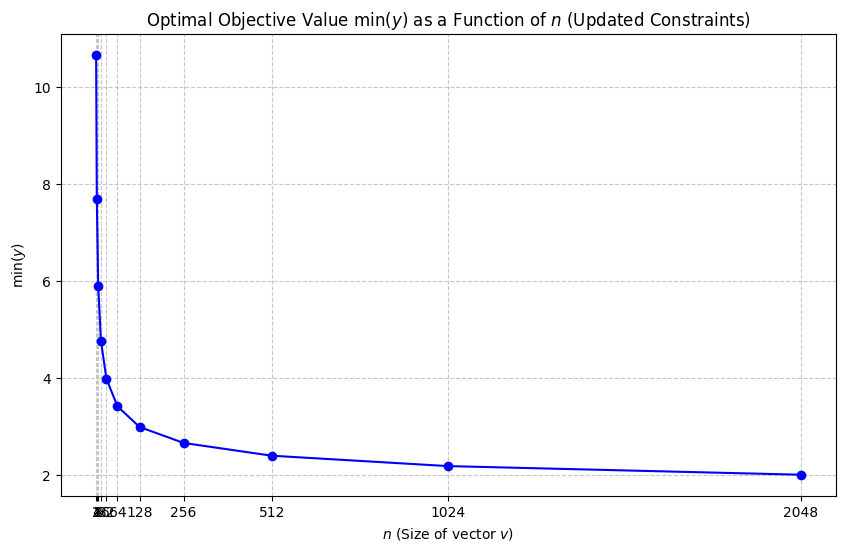

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Simulation (If run locally) ---
results = []
N_values = 2**np.arange(1,12)
for n in N_values:
    min_y = solve_lp(n)
    results.append({'n': n, 'min_y': min_y})

df_results = pd.DataFrame(results)

# --- Plotting ---
plt.figure(figsize=(10, 6))
plt.plot(df_results['n'], df_results['min_y'], marker='o', linestyle='-', color='b')
plt.title(r'Optimal Objective Value $\min(y)$ as a Function of $n$ (Updated Constraints)')
plt.xlabel('$n$ (Size of vector $v$)')
plt.ylabel(r'$\min(y)$')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(N_values)
plt.show()

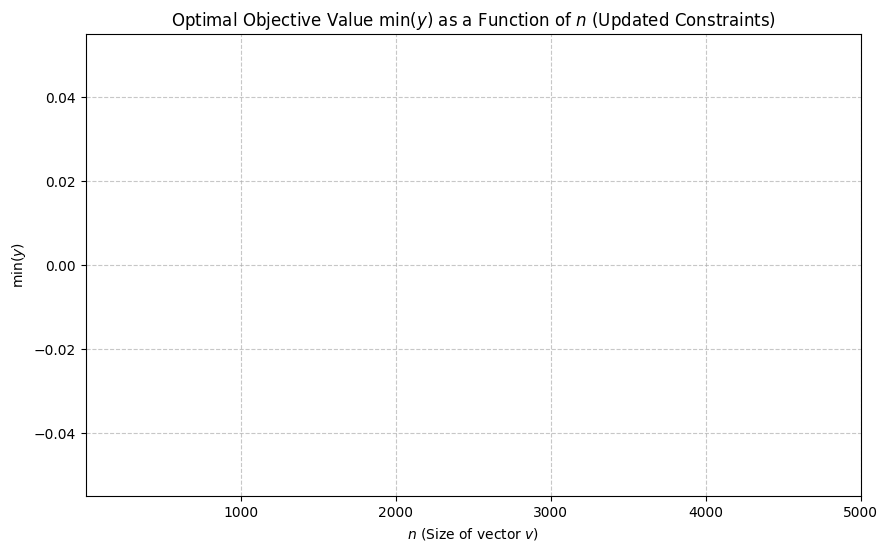

In [53]:
# --- Plotting ---
plt.figure(figsize=(10, 6))
plt.plot(df_results['n'][5:], df_results['min_y'][5:], marker='o', linestyle='-', color='b')
plt.title(r'Optimal Objective Value $\min(y)$ as a Function of $n$ (Updated Constraints)')
plt.xlabel('$n$ (Size of vector $v$)')
plt.ylabel(r'$\min(y)$')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(N_values)
plt.show()

In [24]:
N_values

array([   2,    4,    8,   16,   32,   64,  128,  256,  512, 1024, 2048])

In [ ]:
# for h = 16, lp solution as a function of n
results = []
N_values = range(1000,5001,1000)
for n in N_values:
    min_y = solve_lp(n)
    results.append({'n': n, 'min_y': min_y})

df_results = pd.DataFrame(results)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/1j/t128bzj91wbfj133m93lq6rw0000gn/T/64fd03d6ed79480381cfc68eb4562efc-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/1j/t128bzj91wbfj133m93lq6rw0000gn/T/64fd03d6ed79480381cfc68eb4562efc-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2005 COLUMNS
At line 506505 RHS
At line 508506 BOUNDS
At line 510508 ENDATA
Problem MODEL has 2000 rows, 1001 columns and 504498 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 1998 (-2) rows, 1000 (-1) columns and 503495 (-1003) elements
Perturbing problem by 0.001% of 31.622777 - largest nonzero change 0.00034167894 ( 0.0010804837%) - largest zero change 0.00034159123
0  Obj 0.92042174 Primal inf 36.170918 (17)
64  Obj 

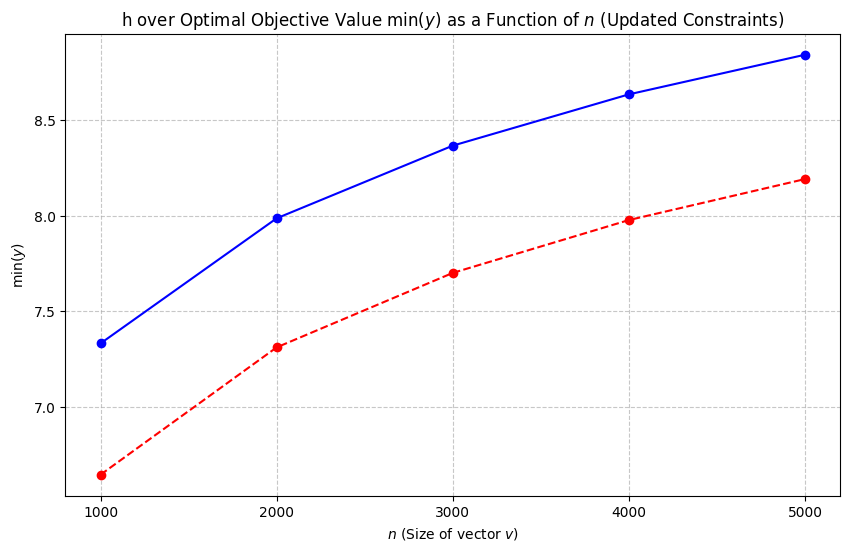

In [ ]:
# for h = 16, plot lp solution as a function of n
# --- Plotting ---
plt.figure(figsize=(10, 6))
# plt.plot(df_results['n'], df_results['min_y'], marker='o', linestyle='-', color='b')
plt.plot(df_results['n'], 16/df_results['min_y'], marker='o', linestyle='-', color='b')
plt.plot(df_results['n'], np.log2(df_results['n'])/1.5, marker='o', linestyle='--', color='r')
plt.title(r'h over Optimal Objective Value $\min(y)$ as a Function of $n$ (Updated Constraints)')
plt.xlabel('$n$ (Size of vector $v$)')
plt.ylabel(r'$\min(y)$')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(N_values)
plt.show()

In [69]:
# for h = 4, lp solution as a function of n
results_2 = []
N_values = 2**np.arange(2,10)
N_values = np.append(N_values,range(1000,5001,1000))
for n in N_values:
    min_y = solve_lp(n,4)
    results_2.append({'n': n, 'min_y': min_y})

df_results_2 = pd.DataFrame(results_2)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/1j/t128bzj91wbfj133m93lq6rw0000gn/T/7d761ad314a647fd8c13888ffd88b448-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/1j/t128bzj91wbfj133m93lq6rw0000gn/T/7d761ad314a647fd8c13888ffd88b448-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 13 COLUMNS
At line 39 RHS
At line 48 BOUNDS
At line 58 ENDATA
Problem MODEL has 8 rows, 5 columns and 24 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 6 (-2) rows, 4 (-1) columns and 17 (-7) elements
0  Obj 1.65 Primal inf 1.449998 (2)
3  Obj 2
Optimal - objective value 2
After Postsolve, objective 2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 2 - 3 iterations time 0.002, Presolve 0.00
Option for print

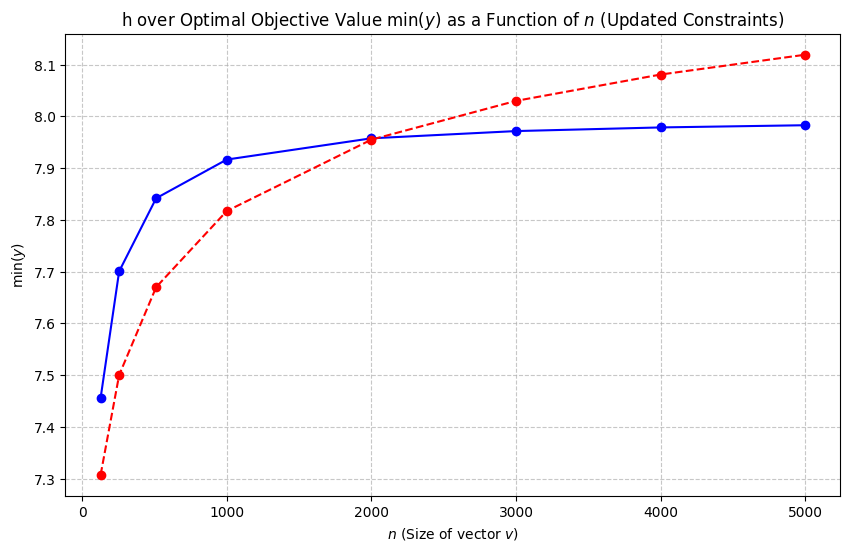

In [107]:
# for h = 4, plot lp solution as a function of n
# --- Plotting ---
plt.figure(figsize=(10, 6))
# plt.plot(df_results['n'], df_results['min_y'], marker='o', linestyle='-', color='b')
plt.plot(df_results_2['n'][5:], 8/df_results_2['min_y'][5:], marker='o', linestyle='-', color='b')
plt.plot(df_results_2['n'][5:], np.log2(np.log2(df_results_2['n']))[5:]+4.5, marker='o', linestyle='--', color='r')
plt.title(r'h over Optimal Objective Value $\min(y)$ as a Function of $n$ (Updated Constraints)')
plt.xlabel('$n$ (Size of vector $v$)')
plt.ylabel(r'$\min(y)$')
plt.grid(True, linestyle='--', alpha=0.7)
# plt.xticks(N_values)
plt.show()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/1j/t128bzj91wbfj133m93lq6rw0000gn/T/10057b51151544a6a69dd1c27b6b4f69-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/1j/t128bzj91wbfj133m93lq6rw0000gn/T/10057b51151544a6a69dd1c27b6b4f69-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 517 COLUMNS
At line 34437 RHS
At line 34950 BOUNDS
At line 35464 ENDATA
Problem MODEL has 512 rows, 257 columns and 33918 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 2 (-510) rows, 2 (-255) columns and 4 (-33914) elements
0  Obj 0.90390625 Primal inf 1.6960918 (2)
1  Obj 1.0039062
Optimal - objective value 1.0039062
After Postsolve, objective 1.0039062, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 1.00

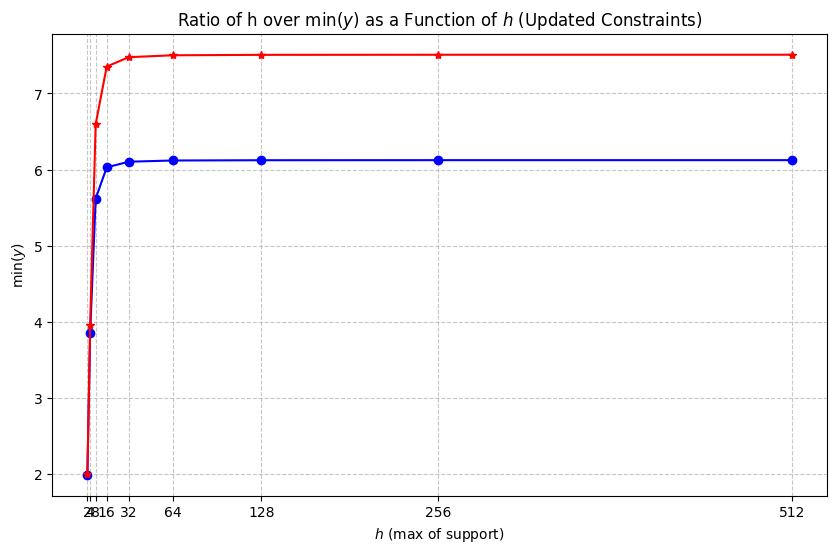

In [ ]:
# --- Simulation (If run locally) ---
results2 = []
h_values = 2**np.arange(1,10)
n = 256
m = 1024
for h in h_values:
    min_y, min_y1 = solve_lp(n,h) , solve_lp(m,h)
    results2.append({'h': h, 'OPT/min_y': h/min_y, 'OPT/min_y1': h/min_y1})

df_results2 = pd.DataFrame(results2)

# --- Plotting ---
plt.figure(figsize=(10, 6))
plt.plot(df_results2['h'], df_results2['OPT/min_y'], marker='o', linestyle='-', color='b')
plt.plot(df_results2['h'], df_results2['OPT/min_y1'], marker='*', linestyle='-', color='r')
plt.title(r'Ratio of h over $\min(y)$ as a Function of $h$ (Updated Constraints)')
plt.xlabel('$h$ (max of support)')
plt.ylabel(r'$\min(y)$')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(h_values)
plt.show()

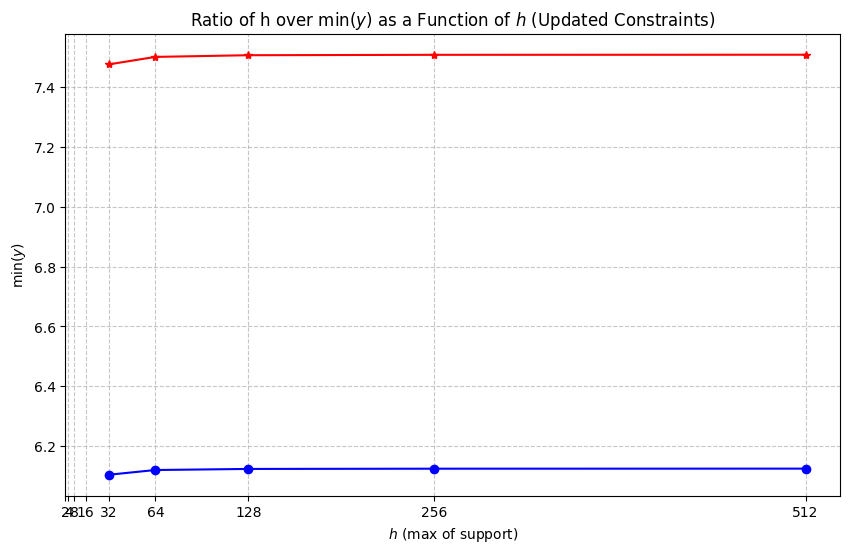

In [38]:
# --- Plotting ---
plt.figure(figsize=(10, 6))
plt.plot(df_results2['h'][4:], df_results2['OPT/min_y'][4:], marker='o', linestyle='-', color='b')
plt.plot(df_results2['h'][4:], df_results2['OPT/min_y1'][4:], marker='*', linestyle='-', color='r')
plt.title(r'Ratio of h over $\min(y)$ as a Function of $h$ (Updated Constraints)')
plt.xlabel('$h$ (max of support)')
plt.ylabel(r'$\min(y)$')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(h_values)
plt.show()